# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Для прогноза предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры. Для успешной сдачи проекта нужно довести метрику до значения 0.59. Также необходимо проверить *F1*-меру на тестовой выборке самостоятельно.

Дополнительно в процессе работы требуется измерять *AUC-ROC*, сравнивать её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

### Загрузка и предварительный анализ данных

Импортируем требуемые для работы модули (библиотеки).

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

Определим требуемые глобальные переменные.

In [2]:
RANDOM_STATE_CONST = 42

Загрузим исходные данные из датасета в переменную (датафрейм) `data`.

In [3]:
# загрузим данные из датасета в датафрейм data
data = pd.read_csv('/datasets/Churn.csv')
# data = pd.read_csv('datasets/Churn.csv')

Проведем предварительный анализ исходных данных.

In [4]:
# выведем первые 10 объектов
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [5]:
# выведем информацию о признаках объектов из датафрейма
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Признаки `RowNumber`, `CustomerId` и `Surname` являются избыточными - первый не несет никакой дополнительной информации, он просто дублирует индексы датафрейма; второй и третий - странно будет, если уход клиента из банка будет зависеть от таких признаков, как его уникальный идентификатор или фамилия. Удалим эти признаки из датасета, чтобы в дальнейшем они не мешали обучению модели.

In [6]:
# удалим лишние столбцы (признаки) из датасета
data.drop(labels=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

Поскольку пропущенных значений признака `Tenure` ок. 10 %, мы не можем просто удалить строки с данными объектами из датафрейма. Заполним эти пропуски и проверим результат.

In [7]:
# посчитаем медианное и ср. арифм. значения признака Tenure
print('Медиана Tenure:', data['Tenure'].median())
print('Ср. арифм. Tenure:', data['Tenure'].mean())

Медиана Tenure: 5.0
Ср. арифм. Tenure: 4.997690023099769


In [8]:
# заполним пропуски столбца Tenure медианным значением
data['Tenure'].fillna(data['Tenure'].median(), inplace=True)

In [9]:
# проверим результат удаления признаков и устранения пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


По результатам дополнительного беглого предварительного анализа (визуального, построением графиков и определением уникальных значений признаков, здесь не приводится для упрощения представляемой работы) было определено, что в данных отсутствуют аномальные значения (выбросы и т.п.). Можно переходить к разделению выборок на обучающую, валидационную и тестовую.

### Разделение выборок

Перед преобразованием категориальных и масштабированием численных признаков разделим датасет на две части: `features` - датафрейм, содержащий объекты с признаками, кроме целевого, и `target` - датафрейм со значениями целевого признака по всем объектам.

In [12]:
# разделим датафрейм на две части
features = data.drop(labels='Exited', axis=1)
target = data['Exited']

Разобъем датафреймы на три выборки: обучающую, валидационную и тестовую, в соотношении 60:20:20.<br>
Предварительно разделим данные датафрейма на промежуточную обучающую и тестовую выборки в соотношении 80:20 - так сформируем тестовую выборку на будущее.<br>
Затем получившуюся промежуточную обучающую выборку еще раз разделим на (вновь) обучающую и валидационную выборки в соотношении 75:25 - так получим обучающую и валидационную выборки, равные 60 % и 20 % от исходных датафреймов `features` и `target`.

In [13]:
# разделим датафреймы на промежуточную обучающую и тестовую выборки
features_train_interm, features_test, target_train_interm, target_test = train_test_split(
    features, target, test_size=0.2, stratify=target, random_state=RANDOM_STATE_CONST)

In [14]:
# разделим получившуюся промежуточную обучающую выборку на обучающую и валидационную выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_interm, target_train_interm, test_size=0.25, stratify=target_train_interm,
    random_state=RANDOM_STATE_CONST)

Проверим, что валидационная и тестовая выборки равны по размеру.

In [15]:
print('Размер валидационной выборки:', features_valid.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер валидационной выборки: (2000, 10)
Размер тестовой выборки: (2000, 10)


Дополнительно определим столбцы датафрейма с категориальными и численными признаками - понядобятся нам далее для отдельной обработки тех и других.

In [16]:
cat_cols = ['Geography', 'Gender'] # категориальные столбцы (признаки)
num_cols = list(features_train.columns.drop(cat_cols)) # численные столбцы (признаки)

### Обработка категориальных признаков

Для обучения модели классификации необходимо предварительно категориальные признаки преобразовать в числовые. Рассмотрим подробнее категориальные признаки из исходного датафрейма.

In [17]:
# подсчитаем количество уникальных значений категориальных признаков
print(data['Geography'].unique())
print(data['Gender'].unique())

['France' 'Spain' 'Germany']
['Female' 'Male']


Категорий немного, можно применить технику OHE (one-hot encoding) для преобразования категориальных признаков.

In [18]:
# определим объект - энкодер
# ohe = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')
ohe = OneHotEncoder(sparse=False, drop='first')

# получим датафреймы с преобразованными категориальными признаками
features_train_cat = pd.DataFrame(ohe.fit_transform(features_train[cat_cols]),
                                  columns=ohe.get_feature_names_out(cat_cols),
                                  index=features_train.index)
features_valid_cat = pd.DataFrame(ohe.transform(features_valid[cat_cols]),
                                  columns=ohe.get_feature_names_out(cat_cols),
                                  index=features_valid.index)
features_test_cat = pd.DataFrame(ohe.transform(features_test[cat_cols]),
                                  columns=ohe.get_feature_names_out(cat_cols),
                                  index=features_test.index)

Объединим датафреймы с преобразованными категориальными признаками и немасштабированными числовыми признаками.

In [19]:
features_train_ohe = pd.concat([features_train_cat, features_train[num_cols]], axis=1)
features_valid_ohe = pd.concat([features_valid_cat, features_valid[num_cols]], axis=1)
features_test_ohe = pd.concat([features_test_cat, features_test[num_cols]], axis=1)

### Нормализация (масштабирование) численных признаков

Выполним масштабирование численных признаков в полученных датафреймах признаков (не целевых) с помощью инструмента `StandardScaler`. Масштабирование выполним следующим образом: обучим скэйлер на обучающей выборке, а потом примением его для преобразования признаков из валидационной и тестовой выборок.

In [20]:
# создадим объект - скэйлер
scaler = StandardScaler()

# получим выборки с отмасштабированными численными признаками
features_train_ohe[num_cols] = scaler.fit_transform(features_train_ohe[num_cols])
features_valid_ohe[num_cols] = scaler.transform(features_valid_ohe[num_cols])
features_test_ohe[num_cols] = scaler.transform(features_test_ohe[num_cols])

Выполними переприсвоение переменных для удобства дальнейшей работы с ними.

In [21]:
features_train = features_train_ohe
features_valid = features_valid_ohe
features_test = features_test_ohe

### Выводы по разделу

По результатам проведенной работы было выполнено следующее:
- кратко проанилизированы данные объектов из исходного датасета;
- исходный датафрейм разбит на обучающую, валидационную и тестовую выборки (отдельно - для признаков и отдельно - для целевого признака);
- преобразованы категориальные и нормализованы численные признаки объектов датасета.<br>
Можно переходить к обучению модели, предварительно проверив баланс классов для определения дисбаланса (если он имеется).

## Исследование задачи

### Исследование баланса классов

Перед обучением ML-модели определим, имеется ли дисбаланс в классах (построим диаграмму, показывающую распределение целевого признака `Exited` в выборках, приведенное к диапазону [0, 1]).

In [22]:
# оценим распределение меток классов
print('target:\n', target.value_counts(normalize=True))
print('target_train:\n', target_train.value_counts(normalize=True))
print('target_valid:\n', target_valid.value_counts(normalize=True))
print('target_test:\n', target_test.value_counts(normalize=True))

target:
 0    0.7963
1    0.2037
Name: Exited, dtype: float64
target_train:
 0    0.796167
1    0.203833
Name: Exited, dtype: float64
target_valid:
 0    0.7965
1    0.2035
Name: Exited, dtype: float64
target_test:
 0    0.7965
1    0.2035
Name: Exited, dtype: float64


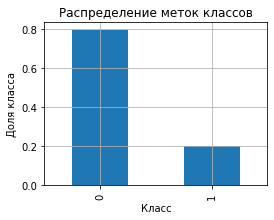

In [23]:
# визуализируем распределение меток классов для большей наглядности
# только для исходной выборки (поскольку доли классов в других выборках примерно аналогичны,
# а при разбиении исходных выборок мы сделали выборки стратифицированными)
target.value_counts(normalize=True).plot(kind='bar', figsize=(4,3), grid=True);
plt.xlabel('Класс'), plt.ylabel('Доля класса')
plt.title('Распределение меток классов');

Наблюдается сильный дисбаланс классов: меток со значением "0" больше, чем меток "1" приблизительно в 4 раза. Тем не менее, попробуем обучить модель, не учитывая обнаруженный дисбаланс.

### Обучение модели без учета дисбаланса классов

#### Модель логистической регрессии

Обучим модель логистической регрессии на несбалансированных данных, посчитаем F1-меру, построим ROC-кривую и вычислим AUC-ROC (на "отложенной", валидационной выборке).

F1-мера: 0.31541218637992835
Значение AUC-ROC: 0.7560164170333662


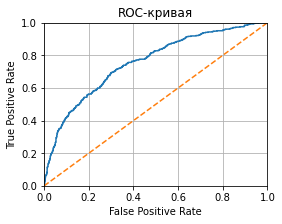

In [24]:
# обучим модель лог. регрессии на несбалансированных данных
model = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE_CONST)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid) # прогнозные значения на валидационной выборке

# построим ROC-кривую и вычислим AUC-ROC
probabilities_one_valid = model.predict_proba(features_valid)[:, 1] # вероятности прогнозных значений класса "1"

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) # данные для построения ROC-кривой

plt.figure(figsize=(4, 3)) # подготовка к визуализации
plt.step(fpr, tpr, where='post'), plt.grid() # визуализация ROC-кривой
plt.plot([0, 1], [0, 1], linestyle='--'); # ROC-кривая случайной модели (выглядит как прямая)
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
plt.title('ROC-кривая');

auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # вычисление AUC-ROC
print('F1-мера:', f1_score(target_valid, predicted_valid)) # F1-мера
print('Значение AUC-ROC:', auc_roc)

Попробуем выполнить взвешивание классов, чтобы таким образом сбалансировать веса классов.

F1-мера: 0.4804270462633452
Значение AUC-ROC: 0.7606589640487946


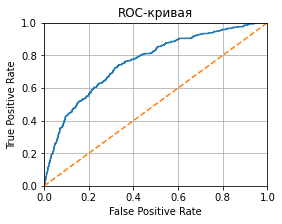

In [25]:
# обучим модель лог. регрессии на несбалансированных данных
model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE_CONST)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid) # прогнозные значения на валидационной выборке

# построим ROC-кривую и вычислим AUC-ROC
probabilities_one_valid = model.predict_proba(features_valid)[:, 1] # вероятности прогнозных значений класса "1"

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) # данные для построения ROC-кривой

plt.figure(figsize=(4, 3)) # подготовка к визуализации
plt.step(fpr, tpr, where='post'), plt.grid() # визуализация ROC-кривой
plt.plot([0, 1], [0, 1], linestyle='--'); # ROC-кривая случайной модели (выглядит как прямая)
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
plt.title('ROC-кривая');

auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # вычисление AUC-ROC
print('F1-мера:', f1_score(target_valid, predicted_valid)) # F1-мера
print('Значение AUC-ROC:', auc_roc)

#### Модель случайного леса

Попробуем вместо логистической регрессии обучить модель случайного леса. Вначале найдем наиболее подходящие значения гиперпараметров `max_depth` и `n_estimators`.<br>
Здесь и далее - поиск параметров будет сперва выполняться с бОльшим шагом итерации и в более широком диапазоне, затем - с меньшим шагом в более узком диапазоне (по результатам первого поиска в каждом случае). Скорее всего, гиперповерхность настраиваемых значений гиперпараметров не унимодальна, а значит, могут быть варианты, не попавшие в диапазон. Но, в конце концов, у нас не ставится задачи найти оптимальные значения гиперпараметров, поэтому позволим себе допущение, что мы ищем в нужных диапазонах.

In [26]:
%%time
# большой шаг, широкий диапазон
best_depth = 0
best_est = 0
best_f1_score = 0
cur_auc_roc = 0

# подбор гиперпараметров max_depth и n_estimators
for depth in range(5, 50, 2):
    for est in range(10, 200, 5):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth,
                                       random_state=RANDOM_STATE_CONST)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid) # прогнозные значения на валидационной выборке
        cur_f1_score = f1_score(target_valid, predicted_valid) # вычисление F1-меры
        probabilities_one_valid = model.predict_proba(features_valid)[:, 1] # вероятности прогнозных 
                                                                            # значений класса "1"
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # вычисление AUC-ROC
        #print('F1-мера:', f1_score(target_valid, predicted_valid), '    Значение AUC-ROC:', auc_roc)
        #print(f'max_depth: {depth},\
                #F1-мера: {cur_f1_score:.4f},\
                #Значение AUC-ROC: {auc_roc:.4f}')
        if cur_f1_score > best_f1_score:
            best_f1_score = cur_f1_score
            cur_auc_roc = auc_roc
            best_depth = depth
            best_est = est
        
print(f'best_depth: {best_depth},\
        best_n_estimators: {best_est},\
        Лучшая F1-мера: {best_f1_score:.4f},\
        Лучшее значение AUC-ROC: {cur_auc_roc:.4f}')

best_depth: 19,        best_n_estimators: 45,        Лучшая F1-мера: 0.5949,        Лучшее значение AUC-ROC: 0.8485
CPU times: total: 15min 19s
Wall time: 15min 27s


In [27]:
%%time
# маленький шаг, узкий диапазон
best_depth = 0
best_est = 0
best_f1_score = 0
cur_auc_roc = 0

# подбор гиперпараметров max_depth и n_estimators
for depth in range(15, 25, 1):
    for est in range(40, 55, 1):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth,
                                       random_state=RANDOM_STATE_CONST)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid) # прогнозные значения на валидационной выборке
        cur_f1_score = f1_score(target_valid, predicted_valid) # вычисление F1-меры
        probabilities_one_valid = model.predict_proba(features_valid)[:, 1] # вероятности прогнозных 
                                                                            # значений класса "1"
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # вычисление AUC-ROC

        if cur_f1_score > best_f1_score:
            best_f1_score = cur_f1_score
            cur_auc_roc = auc_roc
            best_depth = depth
            best_est = est
        
print(f'best_depth: {best_depth},\
        best_n_estimators: {best_est},\
        Лучшая F1-мера: {best_f1_score:.4f},\
        Лучшее значение AUC-ROC: {cur_auc_roc:.4f}')

best_depth: 20,        best_n_estimators: 47,        Лучшая F1-мера: 0.5951,        Лучшее значение AUC-ROC: 0.8458
CPU times: total: 1min 33s
Wall time: 1min 35s


Обучим модель случайного леса на несбалансированных данных, посчитаем F1-меру, построим ROC-кривую и вычислим AUC-ROC (на "отложенной", валидационной выборке) - с учетом найденных выше наилучших значений гиперпараметров.

F1-мера: 0.5950920245398773
Значение AUC-ROC: 0.8458003458003457


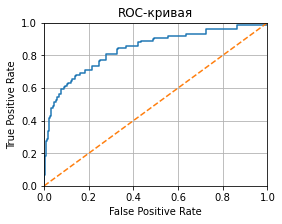

In [28]:
# обучим модель случайного леса на несбалансированных данных
model = RandomForestClassifier(n_estimators=best_est, max_depth=best_depth,
                               random_state=RANDOM_STATE_CONST)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid) # прогнозные значения на валидационной выборке

# построим ROC-кривую и вычислим AUC-ROC
probabilities_one_valid = model.predict_proba(features_valid)[:, 1] # вероятности прогнозных значений класса "1"

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) # данные для построения ROC-кривой

plt.figure(figsize=(4, 3)) # подготовка к визуализации
plt.step(fpr, tpr, where='post'), plt.grid() # визуализация ROC-кривой
plt.plot([0, 1], [0, 1], linestyle='--'); # ROC-кривая случайной модели (выглядит как прямая)
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
plt.title('ROC-кривая');

auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # вычисление AUC-ROC
print('F1-мера:', f1_score(target_valid, predicted_valid)) # F1-мера
print('Значение AUC-ROC:', auc_roc)

### Выводы по разделу

По результатам проведенной работы можно сделать следующие предварительные краткие выводы:
- в исходном датасете (и полученных из него выборках) присутствует очевидный и значительный дисбаланс классов (отношение меток классов целевого признака "0" к "1" приблизительно равно 4:1);
- из двух обученных моделей (логит и случайный лес) наилучшие результаты показывает модель случайного леса (F1-мера равна 0.5951, AUC-ROC - приблизительно 0.8458);
- ROC-кривая для лучшей модели показывает, что полученный классификатор работает точно лучше случайного классификатора и приближается к некоему идеальному классификатору (по внешнему виду).

Формально результат задачи достигнут даже без устранения дисбаланса классов - полученная на модели случайного леса F1-мера превышает заданное значение 0,59. Однако продолжим дальнейшее улучшение модели, перейдя к устранению дисбаланса классов.

## Борьба с дисбалансом

### Увеличение выборок (upsampling)

Попробуем решить проблему дисбаланса классов целевого признака путем увеличения обучающих выборок для класса, меток которого меньше в датасете.<br>
Создадим функцию, входными аргументами которой будут являться выборки признаков и целевого признака, а также кратность увеличения выборок, а выходными аргументами - увеличенные выборки признаков и целевого признака. Затем обработаем обучающие выборки и проверим результат upsampling-а.

In [29]:
# функция увеличения выборок
def upsample(features, target, repeat):
    features_zeros = features[target == 0] # признаки с целевым "0"
    features_ones = features[target == 1] # признаки с целевым "1"
    target_zeros = target[target == 0] # целевой признак "0"
    target_ones = target[target == 1] # целевой признак "1"

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) # увеличенная выборка признаков
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat) # увеличенная выборка целевого признака
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42) # добавим перемешивание объектов
    
    return features_upsampled, target_upsampled

In [30]:
# увеличенные выборки признаков и целевого признака
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
print(features_upsampled.shape) # проверка размерностей получившихся выборок
print(target_upsampled.shape)

(9669, 11)
(9669,)


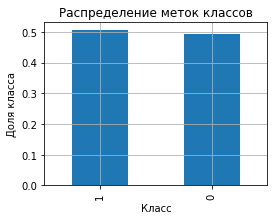

In [31]:
# визуализируем распределение целевого признака в увеличенной выборке
target_upsampled.value_counts(normalize=True).plot(kind='bar', figsize=(4,3), grid=True);
plt.xlabel('Класс'), plt.ylabel('Доля класса')
plt.title('Распределение меток классов');

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Молодец, что проверяешь, что баланс достигнут

### Уменьшение выборок (downsampling)

Попробуем решить проблему дисбаланса классов целевого признака другим способом - посредством уменьшения обучающих выборок для класса, меток которого больше в исходном датасете.<br>
Создадим функцию, входными аргументами которой будут являться выборки признаков и целевого признака, а также доля уменьшения выборок, а выходными аргументами - уменьшенные выборки признаков и целевого признака. Затем обработаем обучающие выборки и проверим результат downsampling-а.

In [32]:
# функция уменьшения выборок
def downsample(features, target, fraction):
    features_zeros = features[target == 0] # признаки с целевым "0"
    features_ones = features[target == 1] # признаки с целевым "1"
    target_zeros = target[target == 0] # целевой признак "0"
    target_ones = target[target == 1] # целевой признак "1"

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=42)]
                                     + [features_ones]) # уменьшенная выборка признаков
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=42)]
                                   + [target_ones]) # уменьшенная выборка целевого признака

    features_downsampled, target_downsampled = shuffle(features_downsampled,
                                                       target_downsampled, random_state=42) # добавим перемешивание объектов
    
    return features_downsampled, target_downsampled

In [33]:
# уменьшенные выборки признаков и целевого признака
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.26)
print(features_downsampled.shape) # проверка размерностей получившихся выборок
print(target_downsampled.shape)

(2465, 11)
(2465,)


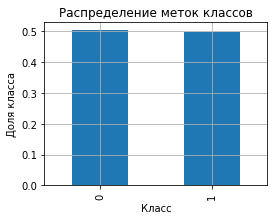

In [34]:
# визуализируем распределение целевого признака в уменьшенной выборке
target_downsampled.value_counts(normalize=True).plot(kind='bar', figsize=(4,3), grid=True);
plt.xlabel('Класс'), plt.ylabel('Доля класса')
plt.title('Распределение меток классов');

### Обучение моделей с увеличенными выборками

#### Модель логистической регрессии

Снова обучим модель логистической регрессии на сбалансированных данных (методом `upsampling`), посчитаем F1-меру, построим ROC-кривую и вычислим AUC-ROC (на "отложенной", валидационной выборке).

F1-мера: 0.47902097902097895
Значение AUC-ROC: 0.7607684726328794


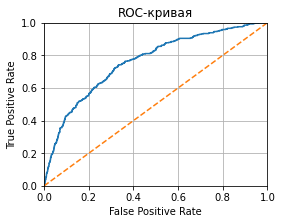

In [35]:
# обучим модель лог. регрессии на сбалансированных данных (upsampling)
model = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE_CONST)
model.fit(features_upsampled, target_upsampled)

predicted_valid = model.predict(features_valid) # прогнозные значения на валидационной выборке

# построим ROC-кривую и вычислим AUC-ROC
probabilities_one_valid = model.predict_proba(features_valid)[:, 1] # вероятности прогнозных значений класса "1"

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) # данные для построения ROC-кривой

plt.figure(figsize=(4, 3)) # подготовка к визуализации
plt.step(fpr, tpr, where='post'), plt.grid() # визуализация ROC-кривой
plt.plot([0, 1], [0, 1], linestyle='--'); # ROC-кривая случайной модели (выглядит как прямая)
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
plt.title('ROC-кривая');

auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # вычисление AUC-ROC
print('F1-мера:', f1_score(target_valid, predicted_valid)) # F1-мера
print('Значение AUC-ROC:', auc_roc)

Опять попробуем выполнить взвешивание классов для сбалансированных выборок.

F1-мера: 0.48
Значение AUC-ROC: 0.7606759301674556


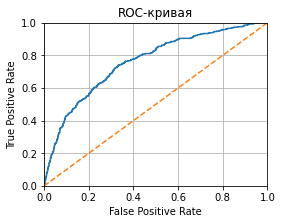

In [36]:
# обучим модель лог. регрессии на сбалансированных данных (upsampling)
model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE_CONST)
model.fit(features_upsampled, target_upsampled)

predicted_valid = model.predict(features_valid) # прогнозные значения на валидационной выборке

# построим ROC-кривую и вычислим AUC-ROC
probabilities_one_valid = model.predict_proba(features_valid)[:, 1] # вероятности прогнозных значений класса "1"

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) # данные для построения ROC-кривой

plt.figure(figsize=(4, 3)) # подготовка к визуализации
plt.step(fpr, tpr, where='post'), plt.grid() # визуализация ROC-кривой
plt.plot([0, 1], [0, 1], linestyle='--'); # ROC-кривая случайной модели (выглядит как прямая)
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
plt.title('ROC-кривая');

auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # вычисление AUC-ROC
print('F1-мера:', f1_score(target_valid, predicted_valid)) # F1-мера
print('Значение AUC-ROC:', auc_roc)

Как видно из значений F1-меры и графиков ROC-кривой, взвешивание классов для модели логистической регрессии для сбалансированных выборок не приносит особого результата: значения метрик приблизительно равны. Т.е., в случае логита встроенное взвешивание классов работает аналогично устранению дисбаланса путем увеличения выборок (можно было не ресэмплировать выборки). Попробуем модель случайного леса. 

#### Модель случайного леса

Теперь снова обучим модель случайного леса уже на сбалансированных выборках (увеличенных), предварительно найдя наиболее подходящие значения гиперпараметров `max_depth` и `n_estimators`.

In [37]:
%%time
# большой шаг, широкий диапазон
best_depth = 0
best_est = 0
best_f1_score = 0
cur_auc_roc = 0

# подбор гиперпараметров max_depth и n_estimators
for depth in range(5, 50, 2):
    for est in range(10, 200, 5):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth,
                                       random_state=RANDOM_STATE_CONST)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid) # прогнозные значения на валидационной выборке
        cur_f1_score = f1_score(target_valid, predicted_valid) # вычисление F1-меры
        probabilities_one_valid = model.predict_proba(features_valid)[:, 1] # вероятности прогнозных 
                                                                            # значений класса "1"
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # вычисление AUC-ROC

        if cur_f1_score > best_f1_score:
            best_f1_score = cur_f1_score
            cur_auc_roc = auc_roc
            best_depth = depth
            best_est = est
        
print(f'best_depth: {best_depth},\
        best_n_estimators: {best_est},\
        Лучшая F1-мера: {best_f1_score:.4f},\
        Лучшее значение AUC-ROC: {cur_auc_roc:.4f}')

best_depth: 13,        best_n_estimators: 110,        Лучшая F1-мера: 0.6424,        Лучшее значение AUC-ROC: 0.8538
CPU times: total: 23min 24s
Wall time: 23min 31s


In [38]:
%%time
# маленький шаг, узкий диапазон
best_depth = 0
best_est = 0
best_f1_score = 0
cur_auc_roc = 0

# подбор гиперпараметров max_depth и n_estimators
for depth in range(8, 20, 1):
    for est in range(104, 118, 1):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth,
                                       random_state=RANDOM_STATE_CONST)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid) # прогнозные значения на валидационной выборке
        cur_f1_score = f1_score(target_valid, predicted_valid) # вычисление F1-меры
        probabilities_one_valid = model.predict_proba(features_valid)[:, 1] # вероятности прогнозных 
                                                                            # значений класса "1"
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # вычисление AUC-ROC

        if cur_f1_score > best_f1_score:
            best_f1_score = cur_f1_score
            cur_auc_roc = auc_roc
            best_depth = depth
            best_est = est
        
print(f'best_depth: {best_depth},\
        best_n_estimators: {best_est},\
        Лучшая F1-мера: {best_f1_score:.4f},\
        Лучшее значение AUC-ROC: {cur_auc_roc:.4f}')

best_depth: 14,        best_n_estimators: 104,        Лучшая F1-мера: 0.6474,        Лучшее значение AUC-ROC: 0.8587
CPU times: total: 4min 11s
Wall time: 4min 11s


Снова обучим модель случайного леса, но уже на сбалансированных данных (увеличенных выборках методом upsampling), посчитаем F1-меру, построим ROC-кривую и вычислим AUC-ROC (на "отложенной", валидационной выборке) - с учетом найденных выше наилучших значений гиперпараметров.

F1-мера: 0.6473551637279596
Значение AUC-ROC: 0.8586560366221382


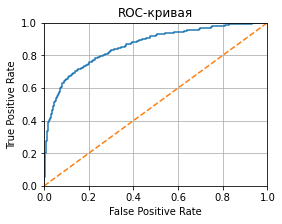

In [39]:
# обучим модель случайного леса на сбалансированных данных
model = RandomForestClassifier(n_estimators=best_est, max_depth=best_depth,
                               random_state=RANDOM_STATE_CONST)
model.fit(features_upsampled, target_upsampled)

predicted_valid = model.predict(features_valid) # прогнозные значения на валидационной выборке

# построим ROC-кривую и вычислим AUC-ROC
probabilities_one_valid = model.predict_proba(features_valid)[:, 1] # вероятности прогнозных значений класса "1"

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) # данные для построения ROC-кривой

plt.figure(figsize=(4, 3)) # подготовка к визуализации
plt.step(fpr, tpr, where='post'), plt.grid() # визуализация ROC-кривой
plt.plot([0, 1], [0, 1], linestyle='--'); # ROC-кривая случайной модели (выглядит как прямая)
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
plt.title('ROC-кривая');

auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # вычисление AUC-ROC
print('F1-мера:', f1_score(target_valid, predicted_valid)) # F1-мера
print('Значение AUC-ROC:', auc_roc)

### Обучение моделей с уменьшенными выборками

#### Модель логистической регрессии

Теперь выполним обучение модели логистической регрессии на сбалансированных данных с уменьшенными обучающими выборками (методом `downsampling`), посчитаем F1-меру, построим ROC-кривую и вычислим AUC-ROC (на "отложенной", валидационной выборке).

F1-мера: 0.4819494584837545
Значение AUC-ROC: 0.7593309796699628


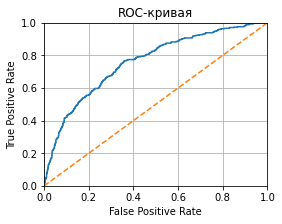

In [40]:
# обучим модель лог. регрессии на сбалансированных данных (downsampling)
model = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE_CONST)
model.fit(features_downsampled, target_downsampled)

predicted_valid = model.predict(features_valid) # прогнозные значения на валидационной выборке

# построим ROC-кривую и вычислим AUC-ROC
probabilities_one_valid = model.predict_proba(features_valid)[:, 1] # вероятности прогнозных значений класса "1"

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) # данные для построения ROC-кривой

plt.figure(figsize=(4, 3)) # подготовка к визуализации
plt.step(fpr, tpr, where='post'), plt.grid() # визуализация ROC-кривой
plt.plot([0, 1], [0, 1], linestyle='--'); # ROC-кривая случайной модели (выглядит как прямая)
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
plt.title('ROC-кривая');

auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # вычисление AUC-ROC
print('F1-мера:', f1_score(target_valid, predicted_valid)) # F1-мера
print('Значение AUC-ROC:', auc_roc)

#### Модель случайного леса

Наконец, обучим модель случайного леса уже на сбалансированных уменьшенных выборках, предварительно найдя наиболее подходящие значения гиперпараметров `max_depth` и `n_estimators`.

In [41]:
%%time
# большой шаг, широкий диапазон
best_depth = 0
best_est = 0
best_f1_score = 0
cur_auc_roc = 0

# подбор гиперпараметров max_depth и n_estimators
for depth in range(5, 50, 2):
    for est in range(10, 200, 5):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth,
                                       random_state=RANDOM_STATE_CONST)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid) # прогнозные значения на валидационной выборке
        cur_f1_score = f1_score(target_valid, predicted_valid) # вычисление F1-меры
        probabilities_one_valid = model.predict_proba(features_valid)[:, 1] # вероятности прогнозных 
                                                                            # значений класса "1"
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # вычисление AUC-ROC

        if cur_f1_score > best_f1_score:
            best_f1_score = cur_f1_score
            cur_auc_roc = auc_roc
            best_depth = depth
            best_est = est
        
print(f'best_depth: {best_depth},\
        best_n_estimators: {best_est},\
        Лучшая F1-мера: {best_f1_score:.4f},\
        Лучшее значение AUC-ROC: {cur_auc_roc:.4f}')

best_depth: 23,        best_n_estimators: 150,        Лучшая F1-мера: 0.6043,        Лучшее значение AUC-ROC: 0.8571
CPU times: total: 8min 52s
Wall time: 8min 53s


In [43]:
%%time
# маленький шаг, узкий диапазон
best_depth = 0
best_est = 0
best_f1_score = 0
cur_auc_roc = 0

# подбор гиперпараметров max_depth и n_estimators
for depth in range(17, 30, 1):
    for est in range(143, 157, 1):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth,
                                       random_state=RANDOM_STATE_CONST)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid) # прогнозные значения на валидационной выборке
        cur_f1_score = f1_score(target_valid, predicted_valid) # вычисление F1-меры
        probabilities_one_valid = model.predict_proba(features_valid)[:, 1] # вероятности прогнозных 
                                                                            # значений класса "1"
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # вычисление AUC-ROC

        if cur_f1_score > best_f1_score:
            best_f1_score = cur_f1_score
            cur_auc_roc = auc_roc
            best_depth = depth
            best_est = est
        
print(f'best_depth: {best_depth},\
        best_n_estimators: {best_est},\
        Лучшая F1-мера: {best_f1_score:.4f},\
        Лучшее значение AUC-ROC: {cur_auc_roc:.4f}')

best_depth: 23,        best_n_estimators: 146,        Лучшая F1-мера: 0.6074,        Лучшее значение AUC-ROC: 0.8572
CPU times: total: 2min 59s
Wall time: 3min 2s


Снова обучим модель случайного леса, но уже на сбалансированных данных (уменьшенных выборках методом downsampling), посчитаем F1-меру, построим ROC-кривую и вычислим AUC-ROC (на "отложенной", валидационной выборке) - с учетом найденных выше наилучших значений гиперпараметров.

F1-мера: 0.6073793755912962
Значение AUC-ROC: 0.8572085182254675


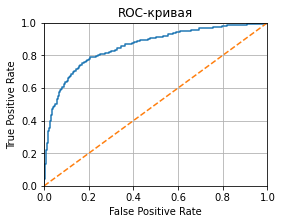

In [45]:
# обучим модель случайного леса на сбалансированных данных
model = RandomForestClassifier(n_estimators=best_est, max_depth=best_depth,
                               random_state=RANDOM_STATE_CONST)
model.fit(features_downsampled, target_downsampled)

predicted_valid = model.predict(features_valid) # прогнозные значения на валидационной выборке

# построим ROC-кривую и вычислим AUC-ROC
probabilities_one_valid = model.predict_proba(features_valid)[:, 1] # вероятности прогнозных значений класса "1"

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) # данные для построения ROC-кривой

plt.figure(figsize=(4, 3)) # подготовка к визуализации
plt.step(fpr, tpr, where='post'), plt.grid() # визуализация ROC-кривой
plt.plot([0, 1], [0, 1], linestyle='--'); # ROC-кривая случайной модели (выглядит как прямая)
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
plt.title('ROC-кривая');

auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # вычисление AUC-ROC
print('F1-мера:', f1_score(target_valid, predicted_valid)) # F1-мера
print('Значение AUC-ROC:', auc_roc)

### Выводы по разделу

По результатам проведенной работы можно сделать следующие выводы:
- учет дисбаланса классов в исходном датасете (и выборках, соответственно) позволяет улучшить качество моделей ML;
- все возможные использованные методы приводят к улучшению качества моделей машинного обучения:
    - взвешивание классов;
    - увеличение обучающих выборок (upsampling);
    - уменьшение обучающих выборок (downsampling);
- модель случайного леса в данной задаче (классификатор/предиктор оттока клиентов банка с имеющимися признаками объектов в датасете) дает лучшие результаты, чем модель логистической регрессии.<br>

В таблице ниже представлены значения F1-меры и AUC-ROC для ранее обученных моделей.

|         | Нсбл.ЛР | Нсбл.ЛР взвш. | Нсбл.СЛ | Up ЛР | Up ЛР взвш. | Up СЛ                      | Down ЛР | Down СЛ |
|---------|---------|---------------|---------|-------|-------------|----------------------------|---------|---------|
| F1-мера | 0.3154  | 0.4804        | 0.5951  | 0.4790| 0.4800      |**<font color=blue> 0.6474**| 0.4819  | 0.6074  |
| AUC-ROC | 0.7560  | 0.7607        | 0.8458  | 0.7608| 0.7607      |**<font color=blue> 0.8587**| 0.7593  | 0.8572  |

В таблице обозначениям соответствуют:
- Нсбл. - несбалансированные данные;
- ЛР - модель логистической регрессии;
- СЛ - модель случайного леса;
- взвш. - взвешенные классы (для модели ЛР);
- Up - увеличенные выборки (upsampling);
- Down - уменьшенные выборки (downsampling).

Представленные результаты показывают, что наилучшие значения F1-меры и одновременно AUC-ROC (выделены полужирным шрифтом синего цвета в таблице) дает модель случайного леса при условии сбалансированности классов в обучающих выборках (методом upsampling - увеличения тех значений меток класса, которых в исходной выборке меньше, до приблизительно равного значения по объему меткам класса, которых в исходной выборке больше).<br>
Можно переходить к финальному тестированию модели на тестовой выборке.

## Тестирование модели

### Проверка наилучшей модели на тестовой выборке

Выполним финальное тестирование выбранной модели, показавшей наилучшие результаты по итогам проведенных ранее работ, - модели случайного леса, обученной на сбалансированных данных.

F1-мера: 0.6108998732572877
Значение AUC-ROC: 0.8563879750320429


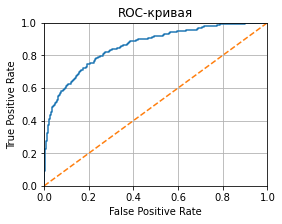

In [47]:
# обучим модель случайного леса на сбалансированных данных
# при найденных наилучших значения гиперпараметров
model = RandomForestClassifier(n_estimators=104, max_depth=14, random_state=RANDOM_STATE_CONST)
model.fit(features_upsampled, target_upsampled)

predicted_test = model.predict(features_test) # прогнозные значения на тестовой выборке

# построим ROC-кривую и вычислим AUC-ROC
probabilities_one_test = model.predict_proba(features_test)[:, 1] # вероятности прогнозных значений класса "1"
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) # данные для построения ROC-кривой

plt.figure(figsize=(4, 3)) # подготовка к визуализации
plt.step(fpr, tpr, where='post'), plt.grid() # визуализация ROC-кривой
plt.plot([0, 1], [0, 1], linestyle='--'); # ROC-кривая случайной модели (выглядит как прямая)
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
plt.title('ROC-кривая');

auc_roc = roc_auc_score(target_test, probabilities_one_test) # вычисление AUC-ROC
print('F1-мера:', f1_score(target_test, predicted_test)) # F1-мера
print('Значение AUC-ROC:', auc_roc)

### Выводы по разделу

Проверка выбранной наилучшей модели (случайного леса) на сбалансированных данных (финальное тестирование модели), на отложенной тестовой выборке показала следующие результаты: F1-мера = 0.6109, AUC-ROC = 0.8564. Эти результаты не значительно хуже полученных ранее при проверке этой же модели на отложенной валидационной выборке (F1-мера = 0.6474, AUC-ROC = 0.8587), что говорит о состоятельности выбранной модели, о возможности применять ее в качестве модели-предиктора для решения поставленной задачи.

## Выводы

По результатам проведенной работы была разработана модель машинного обучения (классификатор), предназначенная для прогноза оттока клиентов банка. Модель была построена на основе имеющегося датасета с историческими данными о поведении клиентов и расторжении договоров с банком.<br>
Созданная модель была проверена на тестовой (отложенной) выборке и показала следующие значения метрик качества (на тестовой же выборке): F1-мера = 0.6109, AUC-ROC = 0.8564. Полученные значения позволяют сделать вывод о решении поставленной задачи (F1-мера превышает заданное значение 0.59), а ROC-кривая и значение AUC-ROC говорят о корректности настройки модели (она работает заведомо лучше случайного предиктора).<br>
Для получения более высоких значений метрик качества, на наш взгляд, возможны, как минимум два пути:
- апробирование других моделей ML (или DL) или ансамблей моделей;
- работа с данными датасета (увеличение объема выборок, конструирование новых признаков, аугментация - насколько применимо, и т.п.).<br>

Тем не менее, полученные результаты свидетельствуют о потенциальной возможности использовать построенную модель для прогноза оттока клиентов банка.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*